<a href="https://colab.research.google.com/github/FahmiFirdausal/AutoEncoder/blob/main/Encoder_Enhance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copied 79 images to 'frames'
Using device: cuda
63 images found in 'frames'
Epoch 1 | Loss: 0.0497 | PSNR: 13.05dB
Epoch 2 | Loss: 0.0419 | PSNR: 13.79dB
Epoch 3 | Loss: 0.0353 | PSNR: 14.53dB
Epoch 4 | Loss: 0.0245 | PSNR: 16.18dB
Epoch 5 | Loss: 0.0151 | PSNR: 18.25dB


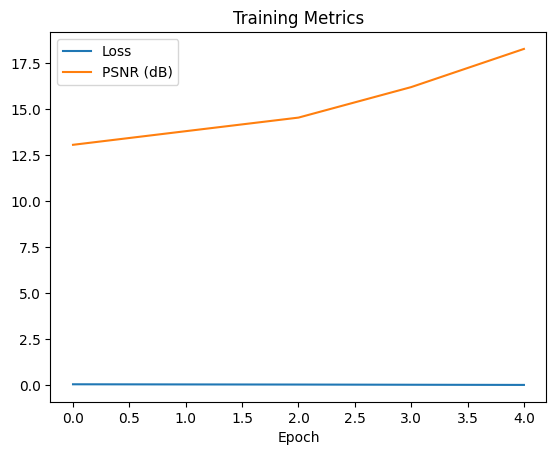

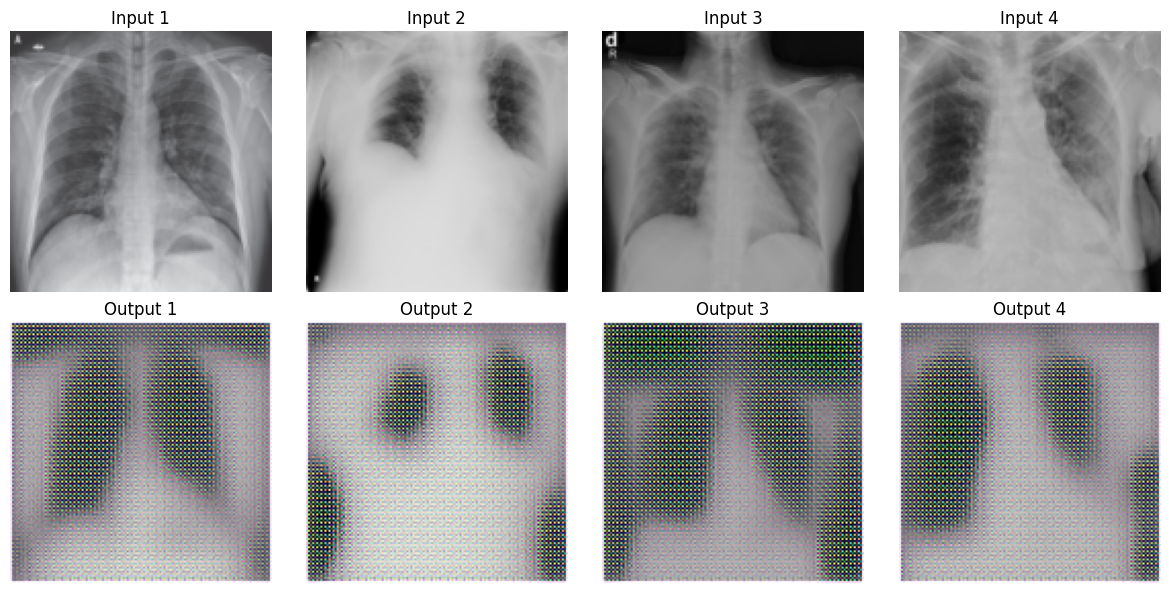

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import os
import kagglehub
import shutil
from math import log10
import numpy as np
import matplotlib.pyplot as plt

# Download dataset via kagglehub
path = kagglehub.dataset_download("pranavraikokte/covid19-image-dataset")

# Pindahkan semua gambar ke folder 'frames'
frames_dir = "frames"
os.makedirs(frames_dir, exist_ok=True)

image_paths = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.lower().endswith((".jpg", ".png")):
            src_path = os.path.join(root, file)
            dst_path = os.path.join(frames_dir, file)
            shutil.copy(src_path, dst_path)
            image_paths.append(dst_path)

print(f"Copied {len(image_paths)} images to '{frames_dir}'")

# Cek device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Transformasi gambar
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Custom Dataset
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None): # Changed _init_ to __init__
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
        print(f"{len(self.image_files)} images found in '{image_dir}'")

    def __len__(self): # Changed _len_ to __len__
        return len(self.image_files)

    def __getitem__(self, idx): # Changed _getitem_ to __getitem__
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, image

# Load dataset
dataset = CustomImageDataset(frames_dir, transform=transform)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self): # Changed _init_ to __init__
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Inisialisasi model
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Buat folder hasil
os.makedirs("results", exist_ok=True)

# Fungsi hitung PSNR
def calculate_psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    return 10 * log10(1 / mse.item())

# Fungsi sharpening image batch
def sharpen_image(img_batch):
    kernel = torch.tensor([[[[0, -1, 0],
                             [-1, 5, -1],
                             [0, -1, 0]]]], dtype=torch.float32, device=img_batch.device)
    kernel = kernel.repeat(3, 1, 1, 1)
    sharpened = F.conv2d(img_batch, kernel, padding=1, groups=3)
    sharpened = torch.clamp(sharpened, 0.0, 1.0)
    return sharpened

# Training loop
losses, psnr_scores = [], []

for epoch in range(5):
    model.train()
    total_loss, total_psnr, count = 0, 0, 0

    for img, _ in loader:
        img = img.to(device)
        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_psnr += calculate_psnr(img, output)
        count += 1

    avg_loss = total_loss / count
    avg_psnr = total_psnr / count
    losses.append(avg_loss)
    psnr_scores.append(avg_psnr)

    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | PSNR: {avg_psnr:.2f}dB")

    # Simpan input, output sharpened per epoch
    sharpened_output = sharpen_image(output)
    for i in range(img.size(0)):
        save_image(img[i].cpu(), f"results/input_epoch{epoch+1}_img{i}.png")
        save_image(sharpened_output[i].cpu(), f"results/output_epoch{epoch+1}_img{i}.png")

# Plot Loss & PSNR
plt.figure()
plt.plot(losses, label='Loss')
plt.plot(psnr_scores, label='PSNR (dB)')
plt.xlabel('Epoch')
plt.legend()
plt.title('Training Metrics')
plt.savefig('results/metrics.png')
plt.show()

 # ... (previous code) ...

# Tampilkan beberapa contoh gambar input dan output
import matplotlib.image as mpimg

num_samples = 4  # jumlah gambar yang ingin ditampilkan
epoch_show = 5   # epoch ke berapa yang mau diambil gambarnya

plt.figure(figsize=(12, 6))
for i in range(num_samples):
    # Load input image
    input_img_path = f"results/input_epoch{epoch_show}_img{i}.png"

    # Check if the file exists before trying to read it
    if os.path.exists(input_img_path):
        input_img = mpimg.imread(input_img_path)
    else:
        print(f"Warning: File not found: {input_img_path}. Skipping.")
        continue  # Skip to the next image

    # Load output image
    output_img_path = f"results/output_epoch{epoch_show}_img{i}.png"

    # Check if the file exists before trying to read it
    if os.path.exists(output_img_path):
        output_img = mpimg.imread(output_img_path)
    else:
        print(f"Warning: File not found: {output_img_path}. Skipping.")
        continue  # Skip to the next image

    # Tampilkan input image
    plt.subplot(2, num_samples, i+1)
    plt.imshow(input_img)
    plt.title(f'Input {i+1}')
    plt.axis('off')

    # Tampilkan output image
    plt.subplot(2, num_samples, num_samples + i+1)
    plt.imshow(output_img)
    plt.title(f'Output {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()